### Importação de Bibliotecas

In [1]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import shap

### Leitura e Tratamento dos Dados

In [2]:
jogosCopa   = pd.read_csv('archive/WorldCupMatches.csv',encoding='utf-8')
ranking     = pd.read_csv('archive/fifa_ranking-2022-10-06.csv.zip')
jogos       = pd.read_csv('archive/results.csv')

In [3]:
jogos =  pd.read_csv('archive/results.csv') #games between national teams
jogos["date"] = pd.to_datetime(jogos["date"])
df_wc = jogos #pre-wc outcomes

rank = pd.read_csv('archive/fifa_ranking-2022-10-06.csv.zip') #rankings
rank["rank_date"] = pd.to_datetime(rank["rank_date"]) 
rank = rank[(rank["rank_date"] >= "2018-1-1")].reset_index(drop=True) #selecting games from the 2022 wc cycle
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States") #ajustando nomes de algumas seleções
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()
rank_wc = rank #dataframe with rankings

#Making the merge
df_wc_ranked = df_wc.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked.dropna(inplace=True)
jogos = df_wc_ranked

In [4]:
import pandas as pd
import re
df =  pd.read_csv('archive/results.csv') #games between national teams
df["date"] = pd.to_datetime(df["date"])
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True) #games at the 2022 wc cycle
df_wc = df #pre-wc outcomes

rank = pd.read_csv('archive/fifa_ranking-2022-10-06.csv.zip') #rankings
rank["rank_date"] = pd.to_datetime(rank["rank_date"]) 
rank = rank[(rank["rank_date"] >= "2018-1-1")].reset_index(drop=True) #selecting games from the 2022 wc cycle
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States") #ajustando nomes de algumas seleções
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()
rank_wc = rank #dataframe with rankings

#Making the merge
df_wc_ranked = df_wc.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)
df_wc_ranked.dropna(inplace=True)

In [5]:
def ultimosJogos(jogos,data,time,qtdJogos=5):
    return jogos[(jogos['date']<data) & ((jogos['home_team']==time) | (jogos['away_team']==time))].sort_values(by='date',ascending=False).head(qtdJogos)

def qtdVit(linha,time,rank,qtdJogos=5):

    jogosC = ultimosJogos(jogos,linha['date'],linha[time],qtdJogos)
    jogosC['Target'] =  np.where(jogosC['home_score']>jogosC['away_score'],jogosC['home_team'],
                       np.where(jogosC['home_score']<jogosC['away_score'],jogosC['away_team'],'Empate'))
    return jogosC[jogosC['Target']==linha[time]]['Target'].count()/linha[rank]

def saldoGols(linha,time,rank):
    jogosC = ultimosJogos(jogos,linha['date'],linha[time],qtdJogos=5)
    golsTeam = jogosC.groupby(['home_team'])['home_score'].sum().reset_index()
    golsTeam.columns = ['pais','gols'] 
    golsAway = jogosC.groupby(['away_team'])['away_score'].sum().reset_index() 
    golsAway.columns = ['pais','gols'] 
    golsMarcados = pd.concat([golsTeam,golsAway])
    golsMarcados = golsMarcados[golsMarcados['pais']==linha[time]].groupby(['pais'])['gols'].sum().reset_index()

    golsSofridosTeam = jogosC.groupby(['home_team'])['away_score'].sum().reset_index()
    golsSofridosTeam.columns = ['pais','gols'] 
    golsSofridosAway = jogosC.groupby(['away_team'])['home_score'].sum().reset_index() 
    golsSofridosAway.columns = ['pais','gols'] 
    golsSofridos = pd.concat([golsSofridosTeam,golsSofridosAway])
    golsSofridos = golsSofridos[golsSofridos['pais']==linha[time]].groupby(['pais'])['gols'].sum().reset_index()

    golsMarcados['saldoDeGols'] = golsMarcados['gols']-golsSofridos['gols']
    golsMarcados = golsMarcados.drop('gols',axis=1)
    return golsMarcados[golsMarcados['pais']==linha[time]]['saldoDeGols']/linha[rank]

def qtdEmp(linha,time,rank):

    jogosC = ultimosJogos(jogos,linha['date'],linha[time],qtdJogos=5)
    jogosC['Target'] =  np.where(jogosC['home_score']>jogosC['away_score'],jogosC['home_team'],
                       np.where(jogosC['home_score']<jogosC['away_score'],jogosC['away_team'],'Empate'))
    return jogosC[jogosC['Target']=='Empate']['Target'].count()

def medScore(linha,time,rank):
    jogosC = ultimosJogos(jogos,linha['date'],linha[time],qtdJogos=5)
    return (jogosC[jogosC['home_team']==linha[time]]['rank_home'].sum()+jogosC[jogosC['away_team']==linha[time]]['rank_away'].sum())/5

In [6]:
#Target -> 1 Vitoria da Casa,2 Vitoria  do visitante e 0  empate
df_wc_ranked['Target'] = np.where(df_wc_ranked['home_score']>df_wc_ranked['away_score'],1,0)
                        #  np.where(df_wc_ranked['home_score']<df_wc_ranked['away_score'],2,0))

In [7]:
df_wc_ranked['Target_V'] = np.where(df_wc_ranked['home_score']>df_wc_ranked['away_score'],1,
                         np.where(df_wc_ranked['home_score']<df_wc_ranked['away_score'],2,0))

In [8]:
df_wc_ranked['flag_amistoso'] = np.where(df_wc_ranked['tournament']=='Friendly',1,0)
df_wc_ranked['flag_is_campo_neutro'] = np.where(df_wc_ranked['neutral']==True,1,0)

In [9]:
golsTeam = jogos.groupby(['home_team'])['home_score'].sum().reset_index()
golsTeam.columns = ['pais','gols'] 
golsAway = jogos.groupby(['away_team'])['away_score'].sum().reset_index() 
golsAway.columns = ['pais','gols'] 
golsMarcados = pd.concat([golsTeam,golsAway])
golsMarcados = golsMarcados.groupby(['pais'])['gols'].sum().reset_index()

golsSofridosTeam = jogos.groupby(['home_team'])['away_score'].sum().reset_index()
golsSofridosTeam.columns = ['pais','gols'] 
golsSofridosAway = jogos.groupby(['away_team'])['home_score'].sum().reset_index() 
golsSofridosAway.columns = ['pais','gols'] 
golsSofridos = pd.concat([golsSofridosTeam,golsSofridosAway])
golsSofridos = golsSofridos.groupby(['pais'])['gols'].sum().reset_index()

golsMarcados['saldoDeGols'] = golsMarcados['gols']-golsSofridos['gols']
golsMarcados = golsMarcados.drop('gols',axis=1)
golsMarcados

,pais,saldoDeGols
0,Afghanistan,-14.0
1,Albania,-11.0
2,Algeria,72.0
3,American Samoa,-20.0
4,Andorra,-59.0
...,...,...
196,Vietnam,17.0
197,Wales,8.0
198,Yemen,-43.0
199,Zambia,-2.0


In [10]:
df_wc_ranked['date'] = df_wc_ranked['date'].astype(str)

In [11]:
jogos

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
0,2018-01-18,Uganda,Namibia,0.0,1.0,African Nations Championship,Marrakech,Morocco,True,446.00,448.00,73.0,-2.0,300.00,274.00,111.0,-7.0
1,2018-01-19,Libya,Nigeria,0.0,1.0,African Nations Championship,Tangier,Morocco,True,389.00,399.00,89.0,1.0,651.00,640.00,51.0,0.0
2,2018-01-19,Rwanda,Equatorial Guinea,1.0,0.0,African Nations Championship,Tangier,Morocco,True,282.00,295.00,116.0,3.0,202.00,187.00,141.0,-5.0
3,2018-01-20,Angola,Cameroon,1.0,0.0,African Nations Championship,Agadir,Morocco,True,200.00,201.00,142.0,1.0,707.00,696.00,45.0,0.0
4,2018-01-20,Congo,Burkina Faso,2.0,0.0,African Nations Championship,Agadir,Morocco,True,369.00,362.00,96.0,0.0,709.00,705.00,44.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,2022-09-27,Albania,Iceland,1.0,1.0,UEFA Nations League,Tirana,Albania,False,1361.81,1361.81,66.0,0.0,1379.61,1379.61,63.0,0.0
3679,2022-09-27,Norway,Serbia,0.0,2.0,UEFA Nations League,Oslo,Norway,False,1488.57,1488.57,36.0,0.0,1549.53,1549.53,25.0,0.0
3680,2022-09-27,Sweden,Slovenia,1.0,1.0,UEFA Nations League,Stockholm,Sweden,False,1563.44,1563.44,20.0,0.0,1372.48,1372.48,65.0,0.0
3681,2022-09-27,Kosovo,Cyprus,5.0,1.0,UEFA Nations League,Pristina,Kosovo,False,1183.90,1183.90,106.0,0.0,1180.52,1180.52,108.0,1.0


In [588]:
df_wc_ranked['QtdVit5UltJHome'] = df_wc_ranked[['date','home_team','rank_home']].apply(qtdVit,args=['home_team','rank_home'],axis=1)
df_wc_ranked['QtdVit5UltJAway'] = df_wc_ranked[['date','away_team','rank_away']].apply(qtdVit,args=['away_team','rank_away'],axis=1)

df_wc_ranked['QtdVit10UltJHome'] = df_wc_ranked[['date','home_team','rank_home']].apply(qtdVit,args=['home_team','rank_home',10],axis=1)
df_wc_ranked['QtdVit10UltJAway'] = df_wc_ranked[['date','away_team','rank_away']].apply(qtdVit,args=['away_team','rank_away',10],axis=1)



In [589]:
df_wc_ranked['QtdVit2UltJHome'] = df_wc_ranked[['date','home_team','rank_home']].apply(qtdVit,args=['home_team','rank_home',2],axis=1)
df_wc_ranked['QtdVit2UltJAway'] = df_wc_ranked[['date','away_team','rank_away']].apply(qtdVit,args=['away_team','rank_away',2],axis=1)

In [590]:
df_wc_ranked['QtdEmp5UltJHome'] = df_wc_ranked[['date','home_team','rank_home']].apply(qtdEmp,args=['home_team','rank_home'],axis=1)
df_wc_ranked['QtdEmp5UltJAway'] = df_wc_ranked[['date','away_team','rank_away']].apply(qtdEmp,args=['away_team','rank_away'],axis=1)

In [578]:
df_wc_ranked['Med5UltJRankHome'] = df_wc_ranked.apply(medScore,args=['home_team','rank_home'],axis=1)
df_wc_ranked['Med5UltJRankAway'] = df_wc_ranked.apply(medScore,args=['away_team','rank_away'],axis=1)

In [591]:
df_wc_ranked['saldoGols5UltJHome'] = df_wc_ranked.apply(saldoGols,args=['home_team','rank_home'],axis=1)
df_wc_ranked['saldoGols5UltJAway'] = df_wc_ranked.apply(saldoGols,args=['home_team','rank_home'],axis=1)

In [220]:
jogosCopa = jogosCopa.drop_duplicates('MatchID')
jogosCopa = jogosCopa.dropna()
jogosCopa = jogosCopa.loc[:,['Year', 'Stage', 'Home Team Name',
  'Home Team Goals', 'Away Team Goals','Win conditions','Away Team Name',
  'Attendance', 'Half-time Home Goals','Half-time Away Goals',
  'RoundID', 'MatchID']]
jogosCopa = jogosCopa.replace('Germany FR','Germany')

In [221]:
jogosCopa['TargetCopa'] = np.where(jogosCopa['Home Team Goals']>jogosCopa['Away Team Goals'],jogosCopa['Home Team Name'],
                      np.where(jogosCopa['Home Team Goals']<jogosCopa['Away Team Goals'],jogosCopa['Away Team Name'],
                      np.where(jogosCopa.apply(lambda x: x['Home Team Name'] in x['Win conditions'],axis=1),jogosCopa['Home Team Name'],
                      np.where(jogosCopa.apply(lambda x: x['Away Team Name'] in x['Win conditions'],axis=1),jogosCopa['Away Team Name'],
                      'Empate'
                    ))))

In [222]:
#Quantidade de Copas Ganhas
#vencedores = jogosCopa[jogosCopa['Stage']=='Final'].groupby(['TargetCopa'])['TargetCopa'].count().sort_values(ascending=False).to_frame('QtdCopas').reset_index()

In [223]:
#df_wc_ranked = df_wc_ranked.merge(vencedores,how='left',right_on=['TargetCopa'],left_on=['home_team'])
#df_wc_ranked = df_wc_ranked.merge(vencedores,how='left',right_on=['TargetCopa'],left_on=['away_team'],suffixes=("_home", "_away")).drop(['TargetCopa_home','TargetCopa_away'],axis=1).fillna(0)

In [602]:
df_wc_ranked = df_wc_ranked.merge(golsMarcados,how='left',right_on=['pais'],left_on=['home_team'])
df_wc_ranked = df_wc_ranked.merge(golsMarcados,how='left',right_on=['pais'],left_on=['away_team'],suffixes=("_home", "_away")).drop(['pais_home','pais_away'],axis=1).fillna(0)

In [582]:
df_wc_ranked['diff_rank'] = df_wc_ranked['rank_home']-df_wc_ranked['rank_away']
df_wc_ranked['diff_points'] = df_wc_ranked['total_points_home']-df_wc_ranked['total_points_away']
# df_wc_ranked['diff_saldo_gols'] = df_wc_ranked['saldoDeGols_home']-df_wc_ranked['saldoDeGols_away']
# df_wc_ranked['diff_5_saldo_gols'] = df_wc_ranked['saldoGols5UltJHome']-df_wc_ranked['saldoGols5UltJAway']

In [603]:
df_wc_ranked.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'Med5UltJRankHome', 'Med5UltJRankAway', 'diff_rank',
       'diff_points', 'Target', 'Target_V', 'flag_amistoso',
       'flag_is_campo_neutro', 'QtdVit5UltJHome', 'QtdVit5UltJAway',
       'QtdVit10UltJHome', 'QtdVit10UltJAway', 'QtdVit2UltJHome',
       'QtdVit2UltJAway', 'QtdEmp5UltJHome', 'QtdEmp5UltJAway',
       'saldoGols5UltJHome', 'saldoGols5UltJAway', 'saldoDeGols_home',
       'saldoDeGols_away'],
      dtype='object')

In [632]:
#X = df_wc_ranked.loc[:,'total_points_home':].drop('Target',axis=1)
X = df_wc_ranked[['Target','diff_rank','diff_points',
                'saldoGols5UltJHome', 'saldoGols5UltJAway','saldoDeGols_home',
                 'saldoDeGols_away','QtdVit10UltJHome', 'QtdVit10UltJAway']].drop('Target',axis=1)
Y =  df_wc_ranked[['Target']]
X

,diff_rank,diff_points,saldoGols5UltJHome,saldoGols5UltJAway,saldoDeGols_home,saldoDeGols_away,QtdVit10UltJHome,QtdVit10UltJAway
0,1.0,-7.00,0.012270,0.012270,-7.0,-37.0,0.006135,0.000000
1,17.0,-85.00,-0.029703,-0.029703,-1.0,19.0,0.000000,0.011905
2,-35.0,245.00,0.000000,0.000000,37.0,-6.0,0.000000,0.000000
3,53.0,-192.00,0.007692,0.007692,-59.0,23.0,0.007692,0.000000
4,114.0,-420.00,-0.011905,-0.011905,-39.0,8.0,0.000000,0.018519
...,...,...,...,...,...,...,...,...
3343,3.0,-17.80,-0.030303,-0.030303,-11.0,-43.0,0.030303,0.031746
3344,11.0,-60.96,0.055556,0.055556,41.0,35.0,0.166667,0.280000
3345,-45.0,190.96,-0.200000,-0.200000,14.0,13.0,0.150000,0.030769
3346,-2.0,3.38,-0.009434,-0.009434,16.0,-50.0,0.028302,0.018519


In [633]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=2)

In [640]:
rf = RandomForestClassifier(random_state=2,max_depth=5,n_estimators=100,warm_start=True) 
model_rf = rf.fit(X_train.fillna(-1000),y_train.fillna(0))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [641]:
predict = model_rf.predict_proba(X_test.fillna(-1000))
previsao = model_rf.predict(X_test.fillna(-1000))
predict_train = model_rf.predict(X_train.fillna(-1000))
previsaoTrain = model_rf.predict_proba(X_train.fillna(-1000))

print(accuracy_score(predict_train,y_train)*100)
print(accuracy_score(previsao,y_test)*100)

74.64788732394366
70.44776119402985


In [644]:
df_wc_ranked['proba_0'] = model_rf.predict_proba(df_wc_ranked[X.columns].fillna(-1000))[:,0]
df_wc_ranked['proba_1'] = model_rf.predict_proba(df_wc_ranked[X.columns].fillna(-1000))[:,1]
df_wc_ranked['proba_1']

0       0.517792
1       0.276499
2       0.802410
3       0.154659
4       0.113015
          ...   
3343    0.460597
3344    0.349206
3345    0.599438
3346    0.551178
3347    0.484661
Name: proba_1, Length: 3348, dtype: float64

In [645]:
df_wc_ranked['diff'] = np.abs(df_wc_ranked['proba_0']-df_wc_ranked['proba_1'])

In [649]:
df_wc_ranked['trecil1'] = pd.cut(df_wc_ranked['proba_0'],10,duplicates='drop')
df_wc_ranked['trecil2'] = pd.cut(df_wc_ranked['proba_1'],10,duplicates='drop')

In [650]:
df_wc_ranked.groupby(['trecil1','Target_V'])[['Target_V']].count().unstack()

Target_V          
Target_V              0    1    2
trecil1                          
(0.031, 0.125]        7  157    0
(0.125, 0.218]       21  261   10
(0.218, 0.31]        55  301   20
(0.31, 0.403]        69  155   32
(0.403, 0.496]       81  186   48
(0.496, 0.589]      192  277  119
(0.589, 0.682]      136  146  154
(0.682, 0.774]       98   78  169
(0.774, 0.867]       80   38  170
(0.867, 0.96]        45   11  232

In [651]:
df_wc_ranked.groupby(['trecil2','Target_V'])[['Target_V']].count().unstack()

Target_V          
Target_V              0    1    2
trecil2                          
(0.039, 0.133]       45   11  232
(0.133, 0.226]       80   38  170
(0.226, 0.318]       98   78  169
(0.318, 0.411]      136  146  154
(0.411, 0.504]      192  277  119
(0.504, 0.597]       81  186   48
(0.597, 0.69]        69  155   32
(0.69, 0.782]        55  301   20
(0.782, 0.875]       21  261   10
(0.875, 0.968]        7  157    0

In [512]:
df_wc_ranked[df_wc_ranked['diff']<=]['Target_V'].value_counts()

1    696
0    434
2    331
Name: Target_V, dtype: int64

In [477]:
resultados = pd.DataFrame({'Jogo':[i for i in range(len(y_test))],'resultEsper':list(y_test['Target']),'previsao':list(previsao),'proba_0':list(x[0] for x in predict), 'proba_1':list(x[1] for x in predict)})

In [486]:
resultados['dif'] = np.abs(resultados['proba_0']-resultados['proba_1'])

In [490]:
resultados[(resultados['dif']>=0) & (resultados['dif']<=10)]['resultEsper'].value_counts()

0    528
1    477
Name: resultEsper, dtype: int64

In [491]:
resultados['previsao'].value_counts()

0    591
1    414
Name: previsao, dtype: int64

In [362]:
resultados = pd.DataFrame({'Jogo':[i for i in range(len(y_test))],'resultEsper':list(y_test['Target']),'previsao':list(previsao),'proba_0':list(x[0] for x in predict), 'proba_1':list(x[1] for x in predict),'proba_2':list(x[2] for x in predict)})

IndexError: index 2 is out of bounds for axis 0 with size 2

In [293]:
resultados['decil_proba0'] = pd.cut(resultados['proba_0'],10,duplicates='drop')
resultados['decil_proba1'] = pd.cut(resultados['proba_1'],10,duplicates='drop') 
resultados['decil_proba2'] = pd.cut(resultados['proba_2'],10,duplicates='drop')

In [324]:
resultados.query('resultEsper==0').groupby(['decil_proba0'])['decil_proba0'].count()/resultados.groupby(['decil_proba0'])['decil_proba0'].count()*100

decil_proba0
(0.043, 0.0783]     8.823529
(0.0783, 0.113]     8.620690
(0.113, 0.148]     10.975610
(0.148, 0.183]     21.818182
(0.183, 0.218]     26.923077
(0.218, 0.253]     24.305556
(0.253, 0.288]     30.769231
(0.288, 0.322]     29.556650
(0.322, 0.357]     24.761905
(0.357, 0.392]     44.444444
Name: decil_proba0, dtype: float64

In [325]:
resultados.query('resultEsper==0').groupby(['decil_proba2'])['decil_proba2'].count()/resultados.groupby(['decil_proba2'])['decil_proba2'].count()

decil_proba2
(0.0146, 0.107]    0.148438
(0.107, 0.198]     0.279762
(0.198, 0.289]     0.280374
(0.289, 0.38]      0.283784
(0.38, 0.471]      0.362069
(0.471, 0.562]     0.220339
(0.562, 0.653]     0.343284
(0.653, 0.744]     0.269231
(0.744, 0.835]     0.096774
(0.835, 0.926]     0.038462
Name: decil_proba2, dtype: float64

In [296]:
resultados.query('resultEsper==0 & previsao==0')

,Jogo,resultEsper,previsao,proba_0,proba_1,proba_2,decil_proba0,decil_proba1,decil_proba2
556,556,0,0,0.391537,0.360329,0.248134,"(0.357, 0.392]","(0.294, 0.387]","(0.198, 0.289]"
574,574,0,0,0.384150,0.371617,0.244233,"(0.357, 0.392]","(0.294, 0.387]","(0.198, 0.289]"
766,766,0,0,0.392256,0.379051,0.228693,"(0.357, 0.392]","(0.294, 0.387]","(0.198, 0.289]"


In [285]:
resultados['previsao'].value_counts()

1    685
2    316
0      4
Name: previsao, dtype: int64

In [278]:
resultados['resultEsper'].value_counts()

1    477
2    287
0    241
Name: resultEsper, dtype: int64

In [642]:
features = X.columns

In [643]:
features_importance = zip(model_rf.feature_importances_, features)
for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))

diff_points: 28.793231%
diff_rank: 24.786379%
saldoDeGols_home: 12.434906%
saldoDeGols_away: 12.162786%
QtdVit10UltJAway: 7.361135%
QtdVit10UltJHome: 5.763385%
saldoGols5UltJHome: 4.469824%
saldoGols5UltJAway: 4.228355%


In [241]:
#Quantidade de Vezes que foi para final
finalistas = pd.concat([jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Home Team Name'])['Home Team Name'].count(),
                        jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Away Team Name'])['Away Team Name'].count()])


In [242]:
#vencedores

In [243]:
ranking.groupby(['country_full'])['rank_change'].mean().sort_values(ascending=False).head(10)

country_full
Kosovo                      1.796610
South Sudan                 1.537736
Türkiye                     1.500000
São Tomé e Príncipe         1.000000
St. Vincent / Grenadines    0.579710
Serbia and Montenegro       0.395349
Bermuda                     0.344720
San Marino                  0.310204
Malta                       0.295031
São Tomé and Príncipe       0.260870
Name: rank_change, dtype: float64

In [244]:
jogosCopa.groupby(['Year'])['Year'].count()

Year
1930.0    18
1934.0    17
1938.0    18
1950.0    22
1954.0    26
1958.0    35
1962.0    32
1966.0    32
1970.0    32
1974.0    38
1978.0    38
1982.0    52
1986.0    52
1990.0    52
1994.0    52
1998.0    64
2002.0    64
2006.0    64
2010.0    64
2014.0    63
Name: Year, dtype: int64

### Variaveis
    var = { 'QTD_COPAS' :0, ✅
            'QtdFinais' :0, ✅
            'QtdSemi'   :0, ✅
            'Ranking'   :0, ✅
            'GOLS_COPAS':0,
            'Vit_5ULT_J':0,
            'Gol_5ULT_J':0
            'VitPorPub': JogVit/Pub
            
    }

<AxesSubplot: xlabel='TargetCopa'>

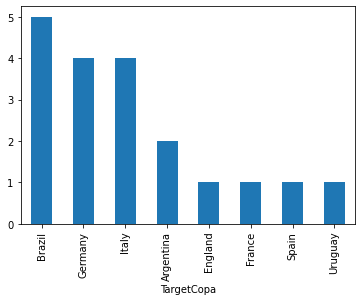

In [245]:
jogosCopa[jogosCopa['Stage']=='Final'].groupby(['TargetCopa'])['TargetCopa'].count().sort_values(ascending=False).plot.bar()

In [246]:
#Quantidade de Vezes que foi para final
(jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False)

Germany           8.0
Brazil            6.0
Italy             6.0
Argentina         5.0
Netherlands       3.0
Czechoslovakia    1.0
England           1.0
France            1.0
Hungary           1.0
Spain             1.0
Sweden            1.0
Uruguay           1.0
dtype: float64

In [247]:
(jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Final'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False).plot.bar

<bound method PlotAccessor.bar of <pandas.plotting._core.PlotAccessor object at 0x7ffabab04370>>

In [248]:
jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Away Team Name'])['Away Team Name'].count()

Away Team Name
Argentina         2
Austria           2
Belgium           1
Brazil            2
Chile             1
Croatia           1
England           1
France            3
Germany           5
Italy             3
Korea Republic    1
Netherlands       2
Portugal          1
Soviet Union      1
Spain             1
Sweden            1
Turkey            1
USA               1
Uruguay           2
Yugoslavia        2
Name: Away Team Name, dtype: int64

In [249]:
#Quantidade de vezes que foi para Semifinais
(jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False)

Germany           12.0
Brazil             8.0
Italy              7.0
France             5.0
Uruguay            4.0
Argentina          4.0
Sweden             3.0
Netherlands        3.0
Portugal           2.0
England            2.0
Croatia            1.0
Belgium            1.0
USA                1.0
Turkey             1.0
Spain              1.0
Soviet Union       1.0
Poland             1.0
Czechoslovakia     1.0
Korea Republic     1.0
Austria            1.0
Hungary            1.0
Bulgaria           1.0
Chile              1.0
Yugoslavia         1.0
dtype: float64

In [250]:
jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Home Team Name'])['Away Team Name'].count()

Home Team Name
Argentina         2
Brazil            6
Bulgaria          1
Czechoslovakia    2
England           1
France            2
Germany           7
Hungary           2
Italy             4
Netherlands       1
Poland            1
Portugal          1
Sweden            2
Uruguay           2
Name: Away Team Name, dtype: int64

<AxesSubplot: >

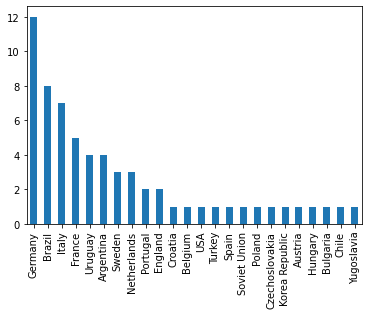

In [251]:
(jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Home Team Name'])['Home Team Name'].count()+\
 jogosCopa[jogosCopa['Stage']=='Semi-finals'].groupby(['Away Team Name'])['Away Team Name'].count()
).fillna(1).sort_values(ascending=False).plot.bar()

In [252]:
# (jogosCopa.groupby(['Home Team Name'])['Home Team Goals'].sum() +\
jogosCopa.groupby(['Away Team Name'])['Away Team Goals'].sum()
# ).sort_values(ascending=False)


Away Team Name
Algeria                        7.0
Angola                         1.0
Argentina                     22.0
Australia                      4.0
Austria                       12.0
                              ... 
rn">Bosnia and Herzegovina     1.0
rn">Republic of Ireland        8.0
rn">Serbia and Montenegro      2.0
rn">Trinidad and Tobago        0.0
rn">United Arab Emirates       2.0
Name: Away Team Goals, Length: 82, dtype: float64

In [253]:
ranking.groupby(['country_full'])['rank'].mean().sort_values().head(10)

country_full
Brazil          3.111801
Spain           5.580745
Argentina       5.745342
Germany         5.975155
France          8.273292
Italy           8.701863
Netherlands     9.363354
England         9.962733
Portugal       10.894410
Mexico         14.512422
Name: rank, dtype: float64

In [254]:
jogosCopa['Home Team Name'].unique()

array(['France', 'USA', 'Yugoslavia', 'Romania', 'Argentina', 'Chile',
       'Uruguay', 'Brazil', 'Paraguay', 'Austria', 'Hungary',
       'Switzerland', 'Sweden', 'Germany', 'Spain', 'Italy',
       'Czechoslovakia', 'Cuba', 'England', 'Turkey', 'Soviet Union',
       'Northern Ireland', 'Mexico', 'Wales', 'Portugal', 'Korea DPR',
       'Peru', 'Belgium', 'Bulgaria', 'German DR', 'Zaire', 'Poland',
       'Australia', 'Scotland', 'Netherlands', 'Haiti', 'Tunisia',
       'Algeria', 'Honduras', 'Canada', 'Morocco', 'Korea Republic',
       'Iraq', 'Denmark', 'rn">United Arab Emirates', 'Costa Rica',
       'Cameroon', 'rn">Republic of Ireland', 'Colombia', 'Norway',
       'Nigeria', 'Saudi Arabia', 'Bolivia', 'Russia', 'Greece',
       'Jamaica', 'South Africa', 'Japan', 'Croatia', 'China PR',
       'Senegal', 'Slovenia', 'Ecuador', 'rn">Trinidad and Tobago',
       'rn">Serbia and Montenegro', 'Angola', 'Czech Republic', 'Togo',
       'Iran', "C�te d'Ivoire", 'Ghana', 'Ukraine', 

In [255]:
jogosCopa.groupby(['Year'])['Year'].count()

Year
1930.0    18
1934.0    17
1938.0    18
1950.0    22
1954.0    26
1958.0    35
1962.0    32
1966.0    32
1970.0    32
1974.0    38
1978.0    38
1982.0    52
1986.0    52
1990.0    52
1994.0    52
1998.0    64
2002.0    64
2006.0    64
2010.0    64
2014.0    63
Name: Year, dtype: int64